# Traffic Data Analysis Notebook

This notebook performs a comprehensive analysis of website traffic and donation data. It includes data quality validation, cleaning, analysis, visualization, and insight generation. The solution is modularized into classes and functions, making it easier to maintain and extend.

**Instructions:**


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging
import warnings

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configure matplotlib inline for Jupyter
%matplotlib inline

# Optional: Increase figure resolution for inline plots
plt.rcParams["figure.dpi"] = 100


In [2]:
import logging
logging.getLogger().setLevel(logging.ERROR)  # Only show errors this should leave out warnings


### Define Data Quality Validator Class

In [3]:
class DataQualityValidator:
    """
    Class to validate data quality and perform checks on the dataset.
    """
    
    @staticmethod
    def check_missing_values(df: pd.DataFrame) -> dict:
        """Check for missing values in each column."""
        missing_counts = df.isna().sum().to_dict()
        for col, count in missing_counts.items():
            if count > 0:
                logger.warning(f"Column '{col}' has {count} missing values.")
        return missing_counts
    
    @staticmethod
    def check_data_types(df: pd.DataFrame) -> dict:
        """Check data types of each column."""
        return df.dtypes.astype(str).to_dict()
    
    @staticmethod
    def check_negative_values(df: pd.DataFrame, columns: list) -> dict:
        """Check for negative values in specified columns."""
        negative_counts = {}
        for col in columns:
            if col in df.columns:
                neg_count = (df[col] < 0).sum()
                if neg_count > 0:
                    logger.warning(f"Column '{col}' has {neg_count} negative values.")
                negative_counts[col] = neg_count
        return negative_counts
    
    @staticmethod
    def check_date_range(df: pd.DataFrame, date_col: str) -> tuple:
        """Check the date range in the dataset."""
        if date_col in df.columns and pd.api.types.is_datetime64_any_dtype(df[date_col]):
            min_date = df[date_col].min().strftime('%Y-%m-%d')
            max_date = df[date_col].max().strftime('%Y-%m-%d')
            logger.info(f"Date range: {min_date} to {max_date}")
            return min_date, max_date
        else:
            logger.warning(f"Column '{date_col}' is not a datetime column or doesn't exist.")
            return None, None
    
    @staticmethod
    def check_unique_values(df: pd.DataFrame, column: str) -> list:
        """Check unique values in a categorical column."""
        if column in df.columns:
            unique_vals = df[column].unique().tolist()
            logger.info(f"Column '{column}' has {len(unique_vals)} unique values: {unique_vals}")
            return unique_vals
        else:
            logger.warning(f"Column '{column}' doesn't exist.")
            return []
    
    @staticmethod
    def validate_dataset(df: pd.DataFrame) -> dict:
        """Run a comprehensive validation on the dataset."""
        results = {
            "row_count": len(df),
            "column_count": len(df.columns),
            "columns": df.columns.tolist(),
            "missing_values": DataQualityValidator.check_missing_values(df),
            "data_types": DataQualityValidator.check_data_types(df),
            "negative_numerics": DataQualityValidator.check_negative_values(
                df, ["visits", "donations", "average_donation_value"]
            ),
        }
        
        if "date" in df.columns:
            if not pd.api.types.is_datetime64_any_dtype(df["date"]):
                logger.warning("'date' column is not in datetime format.")
            else:
                results["date_range"] = DataQualityValidator.check_date_range(df, "date")
        
        if "region" in df.columns:
            results["regions"] = DataQualityValidator.check_unique_values(df, "region")
        
        return results



### Define Data Cleaner

In [4]:
class DataCleaner:
    """
    Class to clean and transform the dataset.
    """
    
    @staticmethod
    def convert_date_column(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
        """Convert string date column to datetime."""
        try:
            df[date_col] = pd.to_datetime(df[date_col])
            logger.info(f"Successfully converted '{date_col}' to datetime.")
        except Exception as e:
            logger.error(f"Failed to convert '{date_col}' to datetime: {str(e)}")
        return df
    
    @staticmethod
    def handle_missing_values(df: pd.DataFrame, numeric_strategy: str = "mean", categorical_strategy: str = "mode") -> pd.DataFrame:
        """
        Handle missing values in the dataset.
        """
        df_clean = df.copy()
        
        # Handle numeric columns
        numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
        for col in numeric_cols:
            missing_count = df[col].isna().sum()
            if missing_count > 0:
                if numeric_strategy == "mean":
                    fill_value = df[col].mean()
                    logger.info(f"Filling {missing_count} missing values in '{col}' with mean: {fill_value:.2f}")
                elif numeric_strategy == "median":
                    fill_value = df[col].median()
                    logger.info(f"Filling {missing_count} missing values in '{col}' with median: {fill_value:.2f}")
                elif numeric_strategy == "zero":
                    fill_value = 0
                    logger.info(f"Filling {missing_count} missing values in '{col}' with zero")
                elif numeric_strategy == "drop":
                    logger.info(f"Dropping {missing_count} rows with missing values in '{col}'")
                    df_clean = df_clean.dropna(subset=[col])
                    continue
                else:
                    raise ValueError(f"Invalid numeric_strategy: {numeric_strategy}")
                
                df_clean[col] = df_clean[col].fillna(fill_value)
        
        # Handle categorical columns
        categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
        for col in categorical_cols:
            missing_count = df[col].isna().sum()
            if missing_count > 0:
                if categorical_strategy == "mode":
                    fill_value = df[col].mode()[0]
                    logger.info(f"Filling {missing_count} missing values in '{col}' with mode: {fill_value}")
                elif categorical_strategy == "unknown":
                    fill_value = "Unknown"
                    logger.info(f"Filling {missing_count} missing values in '{col}' with 'Unknown'")
                elif categorical_strategy == "drop":
                    logger.info(f"Dropping {missing_count} rows with missing values in '{col}'")
                    df_clean = df_clean.dropna(subset=[col])
                    continue
                else:
                    raise ValueError(f"Invalid categorical_strategy: {categorical_strategy}")
                
                df_clean[col] = df_clean[col].fillna(fill_value)
        
        return df_clean
    
    @staticmethod
    def filter_invalid_rows(df: pd.DataFrame) -> tuple:
        """
        Filter out invalid rows from the dataset.
        Returns:
            Tuple[DataFrame, Dict]: Filtered dataframe and dictionary with filter counts
        """
        original_count = len(df)
        filter_counts = {}
        df_filtered = df.copy()
        
        # Filter negative visits
        if "visits" in df.columns:
            neg_visits_count = (df["visits"] < 0).sum()
            if neg_visits_count > 0:
                df_filtered = df_filtered[df_filtered["visits"] >= 0]
                filter_counts["negative_visits"] = neg_visits_count
                logger.info(f"Filtered out {neg_visits_count} rows with negative visits")
        
        # Filter negative donations
        if "donations" in df.columns:
            neg_donations_count = (df["donations"] < 0).sum()
            if neg_donations_count > 0:
                df_filtered = df_filtered[df_filtered["donations"] >= 0]
                filter_counts["negative_donations"] = neg_donations_count
                logger.info(f"Filtered out {neg_donations_count} rows with negative donations")
        
        # Filter negative average_donation_value
        if "average_donation_value" in df.columns:
            neg_value_count = (df["average_donation_value"] < 0).sum()
            if neg_value_count > 0:
                df_filtered = df_filtered[df_filtered["average_donation_value"] >= 0]
                filter_counts["negative_donation_values"] = neg_value_count
                logger.info(f"Filtered out {neg_value_count} rows with negative donation values")
        
        total_filtered = original_count - len(df_filtered)
        filter_counts["total_filtered"] = total_filtered
        logger.info(f"Total rows filtered: {total_filtered} ({total_filtered/original_count:.2%} of data)")
        
        return df_filtered, filter_counts
    
    @staticmethod
    def add_calculated_columns(df: pd.DataFrame) -> pd.DataFrame:
        """Add calculated columns to the dataset."""
        df_with_calcs = df.copy()
        
        # Calculate total donation value
        if all(col in df.columns for col in ["donations", "average_donation_value"]):
            df_with_calcs["total_donation_value"] = df["donations"] * df["average_donation_value"]
            logger.info("Added 'total_donation_value' column")
        
        # Additional time-based features
        if "date" in df.columns and pd.api.types.is_datetime64_any_dtype(df["date"]):
            df_with_calcs["quarter"] = df_with_calcs["date"].dt.to_period("Q").astype(str)
            logger.info("Added 'quarter' column")
            df_with_calcs["month"] = df_with_calcs["date"].dt.month
            logger.info("Added 'month' column")
            df_with_calcs["day_of_week"] = df_with_calcs["date"].dt.day_name()
            logger.info("Added 'day_of_week' column")
        
        return df_with_calcs



### Define Data Analyzer Class

In [5]:
class DataAnalyzer:
    """
    Class to analyze the cleaned dataset.
    """
    
    @staticmethod
    def regional_analysis(df: pd.DataFrame) -> pd.DataFrame:
        """
        Analyze data by region.
        Returns:
            DataFrame: Analysis results by region
        """
        if "region" not in df.columns:
            logger.error("Cannot perform regional analysis: 'region' column not found")
            return pd.DataFrame()
        
        required_cols = ["visits", "donations", "average_donation_value", "total_donation_value"]
        for col in required_cols:
            if col not in df.columns:
                logger.warning(f"Column '{col}' not found for regional analysis")
        
        available_cols = [col for col in required_cols if col in df.columns]
        
        logger.info("Performing regional analysis...")
        region_stats = df.groupby("region")[available_cols].agg({
            "visits": ["sum", "mean"],
            "donations": ["sum", "mean"],
            "average_donation_value": ["mean", "median", "min", "max"],
            "total_donation_value": ["sum", "mean", "median"]
        }).reset_index()
        
        # Flatten MultiIndex columns
        region_stats.columns = ["_".join(col).strip() if col[1] else col[0] for col in region_stats.columns.values]
        
        # Calculate conversion rate (donations/visits)
        if all(col in available_cols for col in ["visits", "donations"]):
            region_stats["conversion_rate"] = region_stats["donations_sum"] / region_stats["visits_sum"]
            region_stats["conversion_rate"] = region_stats["conversion_rate"].round(4)
        
        # Average donation per visitor
        if all(col in available_cols for col in ["visits", "total_donation_value"]):
            region_stats["avg_donation_per_visitor"] = region_stats["total_donation_value_sum"] / region_stats["visits_sum"]
            region_stats["avg_donation_per_visitor"] = region_stats["avg_donation_per_visitor"].round(2)
        
        # Sort by total donation value
        if "total_donation_value_sum" in region_stats.columns:
            region_stats = region_stats.sort_values("total_donation_value_sum", ascending=False)
        
        return region_stats
    
    @staticmethod
    def temporal_analysis(df: pd.DataFrame) -> dict:
        """
        Analyze data over time (monthly, quarterly, day of week).
        Returns:
            dict: Dictionary with different temporal analyses
        """
        results = {}
        
        if "date" not in df.columns or not pd.api.types.is_datetime64_any_dtype(df["date"]):
            logger.error("Cannot perform temporal analysis: 'date' column not found or not in datetime format")
            return results
        
        # Monthly analysis
        logger.info("Performing monthly analysis...")
        monthly_data = df.set_index("date").resample("ME").agg({
            "visits": "sum",
            "donations": "sum",
            "average_donation_value": "mean",
            "total_donation_value": "sum"
        }).reset_index()
        
        monthly_data["month_year"] = monthly_data["date"].dt.strftime("%b %Y")
        monthly_data["conversion_rate"] = (monthly_data["donations"] / monthly_data["visits"]).round(4)
        results["monthly"] = monthly_data
        
        # Quarterly analysis
        logger.info("Performing quarterly analysis...")
        quarterly_data = df.set_index("date").resample("QE").agg({
            "visits": "sum",
            "donations": "sum",
            "average_donation_value": "mean",
            "total_donation_value": "sum"
        }).reset_index()
        
        quarterly_data["quarter"] = quarterly_data["date"].dt.to_period("Q").astype(str)
        quarterly_data["conversion_rate"] = (quarterly_data["donations"] / quarterly_data["visits"]).round(4)
        results["quarterly"] = quarterly_data
        
        # Day of week analysis
        if "day_of_week" in df.columns:
            logger.info("Performing day of week analysis...")
            day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
            dow_data = df.groupby("day_of_week").agg({
                "visits": "sum",
                "donations": "sum",
                "average_donation_value": "mean",
                "total_donation_value": "sum"
            }).reset_index()
            
            dow_data["conversion_rate"] = (dow_data["donations"] / dow_data["visits"]).round(4)
            dow_data["day_of_week"] = pd.Categorical(dow_data["day_of_week"], categories=day_order, ordered=True)
            dow_data = dow_data.sort_values("day_of_week")
            results["day_of_week"] = dow_data
        
        return results



### Define Data Visualizer Class

In [6]:
class DataVisualizer:
    """
    Class to create visualizations from the analyzed data.
    """
    
    @staticmethod
    def setup_style():
        """Set up the visualization style."""
        sns.set(style="whitegrid")
        plt.rcParams["figure.figsize"] = (12, 6)
        plt.rcParams["font.size"] = 12
    
    @staticmethod
    def regional_donation_chart(region_data: pd.DataFrame, output_dir: str = "output"):
        """Create a bar chart of donations by region."""
        DataVisualizer.setup_style()
        
        if "total_donation_value_sum" not in region_data.columns or "region" not in region_data.columns:
            logger.error("Required columns not found for regional donation chart")
            return None
        
        plt.figure(figsize=(12, 6))
        chart = sns.barplot(
            x="region",
            y="total_donation_value_sum",
            data=region_data,
            palette="viridis"
        )
        
        plt.title("Total Donation Value by Region", fontsize=16)
        plt.xlabel("Region", fontsize=14)
        plt.ylabel("Total Donation Value", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        
        # Add values on top of bars
        for p in chart.patches:
            chart.annotate(
                f"{p.get_height():,.0f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='bottom',
                fontsize=11
            )
        
        os.makedirs(output_dir, exist_ok=True)
        file_path = os.path.join(output_dir, "regional_donation_chart.png")
        plt.savefig(file_path, dpi=300, bbox_inches="tight")
        logger.info(f"Saved regional donation chart to {file_path}")
        plt.show()
        plt.close()
        return file_path
    
    @staticmethod
    def conversion_rate_chart(region_data: pd.DataFrame, output_dir: str = "output"):
        """Create a bar chart of conversion rates by region."""
        DataVisualizer.setup_style()
        
        if "conversion_rate" not in region_data.columns or "region" not in region_data.columns:
            logger.error("Required columns not found for conversion rate chart")
            return None
        
        plt.figure(figsize=(12, 6))
        chart = sns.barplot(
            x="region",
            y="conversion_rate",
            data=region_data,
            palette="rocket"
        )
        
        plt.title("Conversion Rate by Region (Donations/Visits)", fontsize=16)
        plt.xlabel("Region", fontsize=14)
        plt.ylabel("Conversion Rate", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        
        # Add values on top of bars
        for p in chart.patches:
            chart.annotate(
                f"{p.get_height():.1%}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='bottom',
                fontsize=11
            )
        
        os.makedirs(output_dir, exist_ok=True)
        file_path = os.path.join(output_dir, "conversion_rate_chart.png")
        plt.savefig(file_path, dpi=300, bbox_inches="tight")
        logger.info(f"Saved conversion rate chart to {file_path}")
        plt.show()
        plt.close()
        return file_path
    
    @staticmethod
    def monthly_trend_chart(temporal_data: pd.DataFrame, output_dir: str = "output"):
        """Create a line chart of monthly donation trends."""
        DataVisualizer.setup_style()
        
        required_cols = ["date", "total_donation_value", "visits", "donations"]
        if not all(col in temporal_data.columns for col in required_cols):
            logger.error("Required columns not found for monthly trend chart")
            return None
        
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot donation value on left y-axis
        color = "tab:blue"
        ax1.set_xlabel("Month", fontsize=14)
        ax1.set_ylabel("Total Donation Value", color=color, fontsize=14)
        ax1.plot(
            temporal_data["date"],
            temporal_data["total_donation_value"],
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=8,
            color=color,
            label="Donation Value"
        )
        ax1.tick_params(axis="y", labelcolor=color)
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
        
        # Plot visits and donations on right y-axis
        ax2 = ax1.twinx()
        color = "tab:red"
        ax2.set_ylabel("Count", color=color, fontsize=14)
        ax2.plot(
            temporal_data["date"],
            temporal_data["visits"],
            marker="s",
            linestyle="--",
            linewidth=2,
            markersize=6,
            color="tab:orange",
            label="Visits"
        )
        ax2.plot(
            temporal_data["date"],
            temporal_data["donations"],
            marker="^",
            linestyle="-.",
            linewidth=2,
            markersize=6,
            color=color,
            label="Donations"
        )
        ax2.tick_params(axis="y", labelcolor=color)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
        
        plt.xticks(temporal_data["date"], temporal_data["date"].dt.strftime("%b %Y"), rotation=45, ha="right")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
        
        plt.title("Monthly Trends: Donation Value, Visits, and Donations", fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        os.makedirs(output_dir, exist_ok=True)
        file_path = os.path.join(output_dir, "monthly_trend_chart.png")
        plt.savefig(file_path, dpi=300, bbox_inches="tight")
        logger.info(f"Saved monthly trend chart to {file_path}")
        plt.show()
        plt.close()
        return file_path



### Define Insights Summary Generator

In [7]:
def generate_insights_summary(region_data: pd.DataFrame, temporal_data: dict) -> str:
    """Generate a summary of insights from the analysis."""
    insights = []
    
    # Regional insights
    if not region_data.empty and "total_donation_value_sum" in region_data.columns:
        top_region = region_data.iloc[0]["region"]
        top_value = region_data.iloc[0]["total_donation_value_sum"]
        insights.append(f"The region with the highest total donation value is {top_region} with {top_value:,.2f}.")
        
        if "conversion_rate" in region_data.columns:
            best_conversion = region_data.loc[region_data["conversion_rate"].idxmax()]
            insights.append(
                f"The highest conversion rate is in {best_conversion['region']} at {best_conversion['conversion_rate']:.2%}."
            )
    
    # Temporal insights
    if "monthly" in temporal_data and not temporal_data["monthly"].empty:
        monthly = temporal_data["monthly"]
        if "total_donation_value" in monthly.columns:
            best_month_idx = monthly["total_donation_value"].idxmax()
            best_month = monthly.iloc[best_month_idx]["month_year"]
            best_month_value = monthly.iloc[best_month_idx]["total_donation_value"]
            insights.append(f"The month with the highest donation value was {best_month} with {best_month_value:,.2f}.")
        
        if len(monthly) > 1 and "total_donation_value" in monthly.columns:
            first_month_value = monthly.iloc[0]["total_donation_value"]
            last_month_value = monthly.iloc[-1]["total_donation_value"]
            change_pct = (last_month_value - first_month_value) / first_month_value * 100
            trend = "increased" if change_pct > 0 else "decreased"
            insights.append(f"Over the analyzed period, monthly donation value has {trend} by {abs(change_pct):.1f}%.")
    
    # Day of week insights
    if "day_of_week" in temporal_data and not temporal_data["day_of_week"].empty:
        dow_data = temporal_data["day_of_week"]
        if "total_donation_value" in dow_data.columns:
            best_day_idx = dow_data["total_donation_value"].idxmax()
            best_day = dow_data.iloc[best_day_idx]["day_of_week"]
            insights.append(f"The day of the week with the highest donation value is {best_day}.")
        if "conversion_rate" in dow_data.columns:
            best_conv_day_idx = dow_data["conversion_rate"].idxmax()
            best_conv_day = dow_data.iloc[best_conv_day_idx]["day_of_week"]
            best_conv_rate = dow_data.iloc[best_conv_day_idx]["conversion_rate"]
            insights.append(f"The day with the highest conversion rate is {best_conv_day} at {best_conv_rate:.2%}.")
    
    return "\n".join(insights)




### Generate Insights Summary

In [11]:
# Set file path and output directory
FILE_PATH = "../data/traffic_data.csv"
OUTPUT_DIR = "output"

# Load data
try:
    df = pd.read_csv(FILE_PATH)
    logger.info(f"Loaded {len(df)} rows and {len(df.columns)} columns from {FILE_PATH}")
except Exception as e:
    logger.error(f"Error loading data: {e}")
    raise

# Validate data quality
validation_results = DataQualityValidator.validate_dataset(df)
print("Data Quality Validation Results:")
print(validation_results)

# Data cleaning
df = DataCleaner.convert_date_column(df)
df = DataCleaner.handle_missing_values(df, numeric_strategy="mean", categorical_strategy="mode")
df_filtered, filter_counts = DataCleaner.filter_invalid_rows(df)
df_enriched = DataCleaner.add_calculated_columns(df_filtered)
print(f"Rows after cleaning: {len(df_enriched)} (Filtered out {filter_counts.get('total_filtered', 0)} rows)")

# Data analysis
region_analysis = DataAnalyzer.regional_analysis(df_enriched)
temporal_analysis = DataAnalyzer.temporal_analysis(df_enriched)




Data Quality Validation Results:
{'row_count': 10000, 'column_count': 5, 'columns': ['date', 'visits', 'donations', 'average_donation_value', 'region'], 'missing_values': {'date': 0, 'visits': 0, 'donations': 0, 'average_donation_value': 0, 'region': 0}, 'data_types': {'date': 'object', 'visits': 'int64', 'donations': 'int64', 'average_donation_value': 'float64', 'region': 'object'}, 'negative_numerics': {'visits': np.int64(0), 'donations': np.int64(0), 'average_donation_value': np.int64(0)}, 'regions': ['Australia', 'Africa', 'South America', 'Europe', 'Asia', 'North America']}
Rows after cleaning: 10000 (Filtered out 0 rows)


### Create visualizations

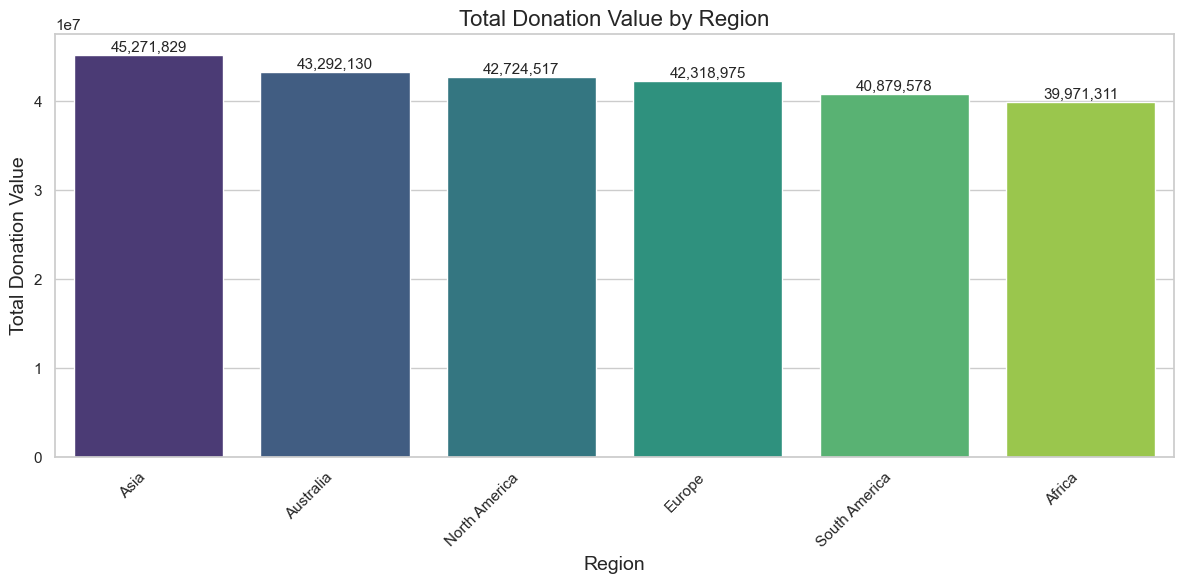

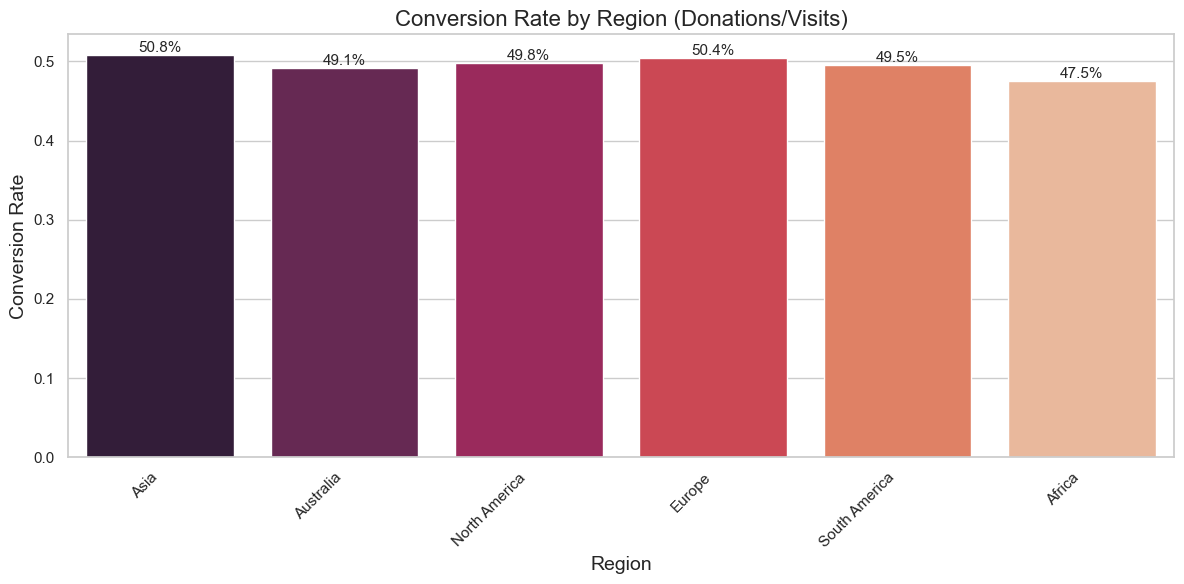

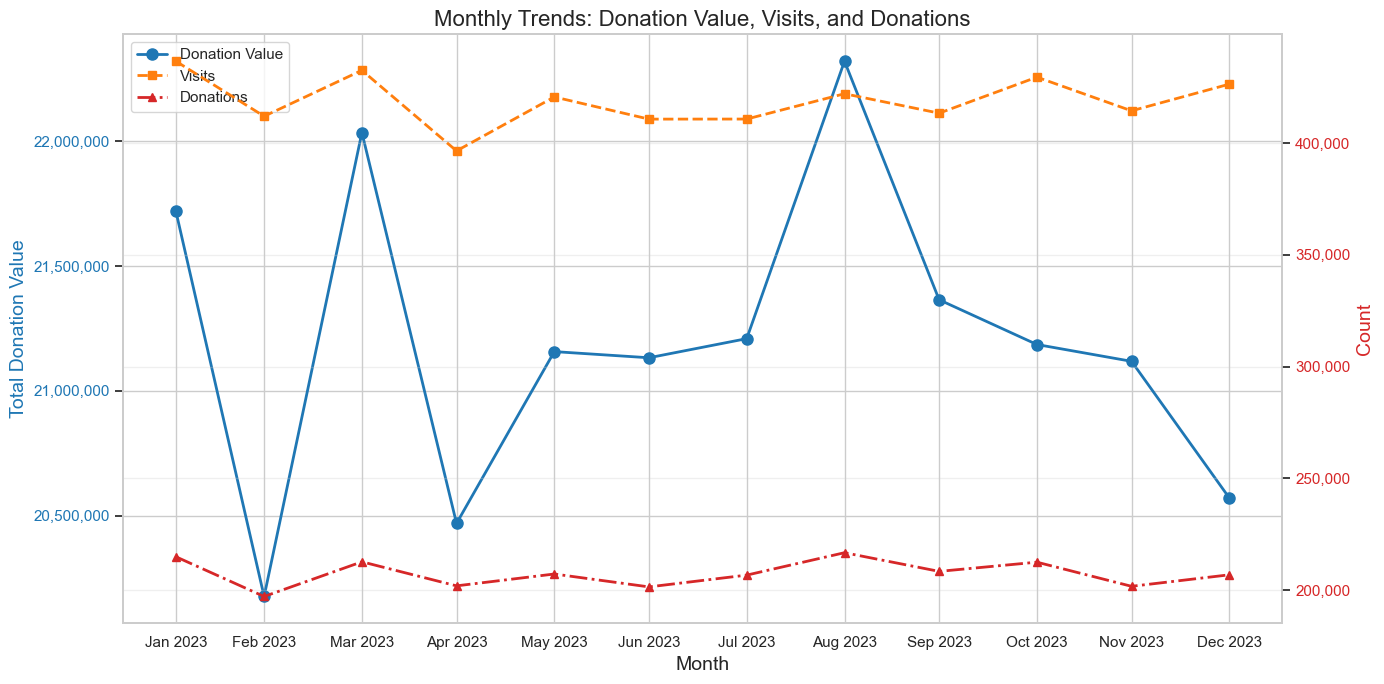

In [ ]:
warnings.filterwarnings('ignore')
DataVisualizer.regional_donation_chart(region_analysis, OUTPUT_DIR)
DataVisualizer.conversion_rate_chart(region_analysis, OUTPUT_DIR)
if "monthly" in temporal_analysis:
    DataVisualizer.monthly_trend_chart(temporal_analysis["monthly"], OUTPUT_DIR)

logger.info("Analysis completed successfully.")


### Insights Summary

In [ ]:
# Generate insights summary
insights = generate_insights_summary(region_analysis, temporal_analysis)
print("\nInsights Summary:")
print(insights)


Insights Summary:
The region with the highest total donation value is Asia with 45,271,829.41.
The highest conversion rate is in Asia at 50.85%.
The month with the highest donation value was Aug 2023 with 22,320,668.83.
Over the analyzed period, monthly donation value has decreased by 5.3%.
The day of the week with the highest donation value is Tuesday.
The day with the highest conversion rate is Wednesday at 48.97%.



### Save Analysis Outputs

In [ ]:
# Save cleaned data and analysis outputs
df_enriched.to_csv(os.path.join(OUTPUT_DIR, "cleaned_data.csv"), index=False)
region_analysis.to_csv(os.path.join(OUTPUT_DIR, "region_analysis.csv"), index=False)
for key, dfa in temporal_analysis.items():
    dfa.to_csv(os.path.join(OUTPUT_DIR, f"{key}_analysis.csv"), index=False)

with open(os.path.join(OUTPUT_DIR, "insights.txt"), "w") as f:
    f.write(insights)